<a href="https://colab.research.google.com/github/osgeokr/GEE-PAM-Book/blob/main/Chapter2_Utilizing_GEE_Data_and_Local_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Earth Engine Data Catalog

[Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets)는 Google Earth Engine에서 사용 가능한 데이터셋 및 이미지 컬렉션에 대한 정보를 포함하는 온라인 데이터 리포지토리입니다. 데이터셋(Dataset)은 Google Earth Engine에서 관리되는 정형 데이터를, 이미지 컬렉션(Image Collection)은 동일한 데이터셋의 여러 시간 스탬프들을 묶어서 처리하기 쉽게 만든 개념입니다.

In [1]:
%pip install -U -q rasterio
%pip install -U -q ffmpeg-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 23.9 MB/s eta 0:00:00


In [2]:
import ee
import geemap

import os
import matplotlib.pyplot as plt
import rasterio

In [3]:
# Earth Engine 인증
ee.Authenticate()

# Earth Engine 초기화
ee.Initialize(project='ee-foss4g')

### FeatureCollection: WDPA

In [4]:
# WDPA 데이터셋 불러오기
wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")

In [5]:
wdpa_id = 30712 # 해당 ID를 가진 WDPA 경계 선택
protected_area = wdpa.filter(ee.Filter.eq('WDPAID', wdpa_id))

In [6]:
# 선택된 보호지역의 이름 가져오기
area_name = protected_area.first().get('NAME').getInfo()
print("Name:", area_name)

Name: Byeonsanbando


In [7]:
# 지도 너비, 높이, 기본 지도 설정
Map = geemap.Map(width="800px", height="500px", basemap='Esri.WorldImagery')

In [8]:
Map.addLayer(protected_area, {'color': 'green'}, area_name) # 레이어 추가
Map.centerObject(protected_area, 12) # 지도의 중심 설정
Map # 지도 객체 출력

Map(center=[35.647398915313346, 126.57637017154774], controls=(WidgetControl(options=['position', 'transparent…

### Image: NASA SRTM Digital Elevation 30m

데이터셋(Dataset)은 Google Earth Engine에서 관리되는 정형 데이터를, 이미지 컬렉션(Image Collection)은 동일한 데이터셋의 여러 시간 스탬프들을 묶어서 처리하기 쉽게 만든 개념입니다.

Shuttle Radar Topography Mission (SRTM)은 디지털 고도 데이터(digital elevation data)입니다.  SRTM V3 제품(SRTM Plus)은 NASA JPL에서 제공되며, 1아크초(약 30m)의 해상도로 제공됩니다. 이 데이터셋은 상용 소스로 채워지거나 공백을 포함하는 다른 버전과 달리, 오픈 소스 데이터(ASTER GDEM2, GMTED2010 및 NED)를 사용하여 공백을 채우는 과정을 거쳤습니다.



In [9]:
# FAO GAUL: Global Administrative Unit Layers 2015, Country Boundaries
countries = ee.FeatureCollection("FAO/GAUL/2015/level0")

# 'ADM0_NAME' 필드를 기준으로 '대한민국' 필터링
kr = countries.filter(ee.Filter.eq('ADM0_NAME', 'Republic of Korea'))

# 지도 생성
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

# 지도에 경계 표시
Map.centerObject(kr, 7) # 경계 중심으로 지도 확대
Map.addLayer(kr, {}, "Republic of Korea")

# 지도 출력
Map

Map(center=[36.34449219000809, 127.80177597242088], controls=(WidgetControl(options=['position', 'transparent_…

In [10]:
# SRTM Digital Elevation 30m
SRTM = ee.Image('USGS/SRTMGL1_003')
elevation = SRTM.select('elevation')
visParams = {
    'min': 0,
    'max': 5000,
    'palette': ['000000','006600', '009900','33CC00','996600','CC9900','CC9966','FFFFFF']}

# 지도 생성
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

Map.centerObject(kr, 4) # 경계 중심으로 지도 확대
Map.addLayer(elevation, visParams, 'Elevation')
Map

Map(center=[36.34449219000809, 127.80177597242088], controls=(WidgetControl(options=['position', 'transparent_…

In [11]:
# 대한민국 영역으로 잘라내기
elevation_kr = elevation.clipToCollection(kr)

# 데이터를 Google Drive에 저장
geemap.ee_export_image_to_drive(
    elevation_kr,
    description='elevation',
    folder='export',
    region=kr.geometry(),
    scale=100,
    maxPixels=1e13
)

### Image: WorldClim BIO Variables V1

WorldClim BIO Variables V1은 전세계적으로 널리 사용되는 기후 데이터셋 하나로, 지구 환경 연구와 모델링에 활용되는 중요한 데이터셋입니다.

In [12]:
# WorldClim BIO Variables V1
worldclim = ee.Image('WORLDCLIM/V1/BIO')

bio01 = worldclim.select('bio01').multiply(0.1)
visParams = {
    'min': -23,
    'max': 30,
    'palette': ['blue', 'purple', 'cyan', 'green', 'yellow', 'red']}

# 지도 생성
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

Map.centerObject(kr, 4) # 경계 중심으로 지도 확대
Map.addLayer(bio01, visParams, 'Annual mean temperature')
Map

Map(center=[36.34449219000809, 127.80177597242088], controls=(WidgetControl(options=['position', 'transparent_…

In [13]:
# 각각의 변수를 정의하여 대한민국 영역으로 잘라내고 GeoTIFF 파일로 저장
for i in range(1, 20):
    # WorldClim BIO Variables V1 데이터셋에서 해당 변수 선택
    band_name = 'bio{:02d}'.format(i)
    image = worldclim.select(band_name)

    # 'bio01', 'bio02', 'bio05'부터 'bio11'까지는 0.1을 곱하고, 'bio04'는 0.02를 곱함
    if i in [1, 2, 5, 6, 7, 8, 9, 10, 11]:
        image = image.multiply(0.1)
    elif i == 4:
        image = image.multiply(0.02)
    else:
        image = image.multiply(1.0)

    # 대한민국 영역으로 잘라내기
    image_kr = image.clipToCollection(kr)

    # 저장할 파일 경로
    output_file = 'bio{:02d}.tif'.format(i)

    # GeoTIFF로 저장
    geemap.ee_export_image(image_kr, filename=output_file, region=kr.geometry(), scale=1000)

Generating URL ...
Please wait ...
Data downloaded to /content/bio01.tif
Generating URL ...
Please wait ...
Data downloaded to /content/bio02.tif
Generating URL ...
Please wait ...
Data downloaded to /content/bio03.tif
Generating URL ...
Please wait ...
Data downloaded to /content/bio04.tif
Generating URL ...
Please wait ...
Data downloaded to /content/bio05.tif
Generating URL ...
Please wait ...
Data downloaded to /content/bio06.tif
Generating URL ...
Please wait ...
Data downloaded to /content/bio07.tif
Generating URL ...
Please wait ...
Data downloaded to /content/bio08.tif
Generating URL ...
Please wait ...
Data downloaded to /content/bio09.tif
Generating URL ...
Please wait ...
Data downloaded to /content/bio10.tif
Generating URL ...
Please wait ...
Data downloaded to /content/bio11.tif
Generating URL ...
Please wait ...
Data downloaded to /content/bio12.tif
Generating URL ...
Please wait ...
Data downloaded to /content/bio13.tif
Generating URL ...
Please wait ...
Data downloaded 

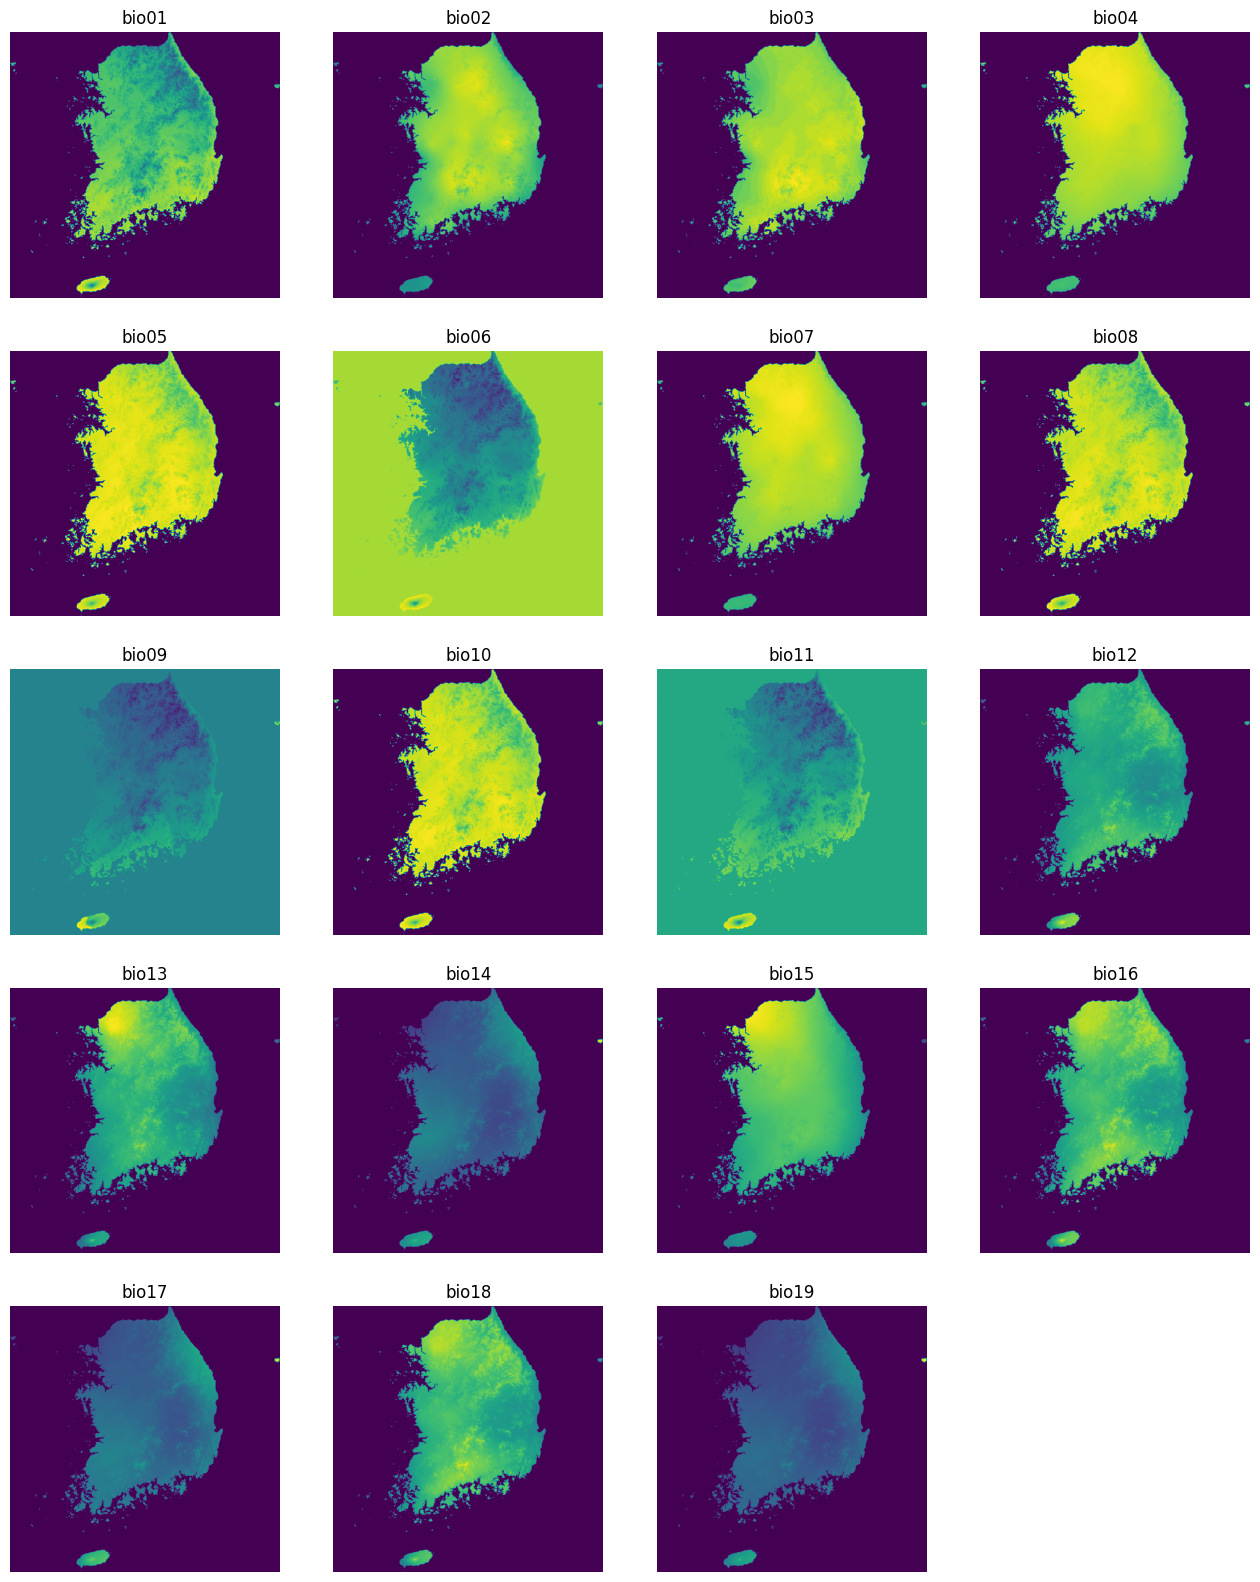

In [14]:
# 변수 이름 리스트
variables = ['bio{:02d}'.format(i) for i in range(1, 20)]

# 차트 생성
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(16, 20))

# 변수들을 순회하며 플롯 그리기
for i, var in enumerate(variables):
    # GeoTIFF 파일 경로
    file_path = f'{var}.tif'

    # GeoTIFF 파일을 rasterio로 열어 데이터 가져오기
    with rasterio.open(file_path) as src:
        data = src.read(1)

    # 플롯 그리기
    row_idx = i // 4
    col_idx = i % 4
    ax = axes[row_idx, col_idx]
    im = ax.imshow(data, cmap='viridis', aspect='auto')
    ax.set_title(var)
    ax.axis('off')

# 빈 칸 숨기기
for i in range(len(variables), 20):
    row_idx = i // 4
    col_idx = i % 4
    axes[row_idx, col_idx].axis('off')

# 차트 저장
plt.savefig('worldclim_bio_vars.png', bbox_inches='tight', pad_inches=0.1)

# 차트 출력
plt.show()

### ImageCollection: MOD44B.006 Terra MODIS Vegetation Continuous Fields(VCF)

지표면 식생 피복을 세 가지 지면 피복 구성요소의 변화로 나타내는 전세계 데이터입니다.

* 수목 피복 확률(percent tree cover)
* 비수목 피복 확률(percent non-tree cover)
* 비식생(나지) 확률 (percent non-vegetated, bare)

MODIS 기기는 Terra와 Aqua 위성 모두에서 작동하고 있습니다. 이 기기는 2,330 km의 관측 폭을 갖고 있으며 지구 전체 표면을 1일에서 2일에 한 번씩 관측합니다. 기기의 감지기는 0.405에서 14.385 µm까지 36개의 스펙트럼 밴드를 측정하며, 데이터를 250m, 500m, 1,000m의 세 가지 공간 해상도에서 획득합니다. VCF 데이터셋의 각 변수들은 250m급 공간해상도로 제공됩니다.

In [15]:
# Terra Vegetation Continuous Fields Yearly Global 250m
MODIS = ee.ImageCollection('MODIS/006/MOD44B')

# 날짜 필터링 및 녹지 지수 선택
filtered_MODIS = MODIS.filterDate('2003-01-01', '2020-12-31')
selected_MODIS = filtered_MODIS.select('Percent_Tree_Cover')

# 녹지 지수의 중앙값 계산
MedianPTC = selected_MODIS.median()
visParams = {
    'min': 0,
    'max': 100,
    'palette': ['bbe029', '0a9501', '074b03']}

# 지도 생성
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

Map.centerObject(kr, 7) # 경계 중심으로 지도 확대
Map.addLayer(MedianPTC, visParams, 'Percent Tree Cover')
Map

Map(center=[36.34449219000809, 127.80177597242088], controls=(WidgetControl(options=['position', 'transparent_…

### Image Collection: Dynamic World(다이내믹 월드)

[Dynamic World](https://dynamicworld.app/)는 10m급 Sentinel-2(센티널 2호) 영상에서 딥러닝(deep learning)을 활용하여 전세계적으로 일관된 준실시간(NRT: Near Real-Time) 토지이용/피복(LULC: Land Use Land Cover) 분류를 위해 개발된 새로운 자동화 접근 방식(automated approach)입니다.

In [16]:
# 변산반도국립공원 영역을 추출하는 함수 정의
def get_boundary():
    roi = ee.FeatureCollection("WCMC/WDPA/current/polygons") \
        .filter(ee.Filter.eq("NAME", "Byeonsanbando")) \
        .geometry()
    return roi

# 변산반도국립공원 경계 추출
region = get_boundary()

In [17]:
# 지도 생성
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

# 지도에 경계 표시
Map.centerObject(region, 12) # 경계 중심으로 지도 확대
Map.addLayer(region, {}, "Byeonsanbando National Park")

# 지도 출력
Map

Map(center=[35.64736592673224, 126.57639325951935], controls=(WidgetControl(options=['position', 'transparent_…

In [18]:
# 날짜 범위 설정
start_date = '2022-01-01'
end_date = '2023-01-01'

In [19]:
# Sentinel-2 영상 합성(image composite)
image = geemap.dynamic_world_s2(region, start_date, end_date)
vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
Map.addLayer(image, vis_params, 'Sentinel-2 image')

# 지도 출력
Map

Map(center=[35.64736592673224, 126.57639325951935], controls=(WidgetControl(options=['position', 'transparent_…

In [20]:
# Dynamic World 토지피복 합성(land cover composite)
landcover = geemap.dynamic_world(region, start_date, end_date, return_type='hillshade')
Map.addLayer(landcover, {}, 'Land Cover')
Map

Map(center=[35.64736592673224, 126.57639325951935], controls=(WidgetControl(options=['position', 'transparent_…

In [21]:
# 지도에 범례 추가
Map.add_legend(title="Dynamic World Land Cover", builtin_legend='Dynamic_World')
Map

Map(center=[35.64736592673224, 126.57639325951935], controls=(WidgetControl(options=['position', 'transparent_…

In [22]:
# Dynamic World 토지피복 확률(probability)
landcover = geemap.dynamic_world(region, start_date, end_date, return_type='probability')
Map.addLayer(landcover, {}, 'Land Cover probability')
Map.remove_legend() # 범례 삭제
Map

Map(center=[35.64736592673224, 126.57639325951935], controls=(WidgetControl(options=['position', 'transparent_…

In [23]:
# Dynamic World 토지피복 가시화(visualize)
landcover = geemap.dynamic_world(region, start_date, end_date, return_type='visualize')
Map.addLayer(landcover, {}, 'Land Cover visualize')
Map

Map(center=[35.64736592673224, 126.57639325951935], controls=(WidgetControl(options=['position', 'transparent_…

In [24]:
timelapse = geemap.landsat_timelapse(
    region,
    out_gif='landsat.gif',
    start_year=1984,
    end_year=2022,
    start_date='01-01',
    end_date='12-31',
    bands=['SWIR1', 'NIR', 'Red'],
    frames_per_second=5,
    title='Landsat Timelapse',
    progress_bar_color='blue',
    mp4=True,
)
geemap.show_image(timelapse)

Generating URL...
Please wait ...
The GIF image has been saved to: /content/landsat.gif


Output()

In [92]:
roi = ee.Geometry.BBox(124, 33, 132, 43)

timelapse = geemap.modis_ndvi_timelapse(
    roi,
    out_gif='ndvi.gif',
    data='Terra',
    band='NDVI',
    start_date='2000-01-01',
    end_date='2023-12-31',
    frames_per_second=3,
    title='MODIS NDVI Timelapse',
    overlay_data='countries',
)
geemap.show_image(timelapse)

Generating URL...
Please wait ...
The GIF image has been saved to: /content/ndvi.gif


Output()

### Image Collection: [Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#bands)

In [82]:
# 팔공산: WDPA ID가 555571373인 보호지역
wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons") \
    .filter(ee.Filter.eq('WDPAID', 555571373))
aoi = wdpa.geometry()

# Sentinel-2 이미지 컬렉션 선택 및 필터링
collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterDate('2024-01-01', '2024-01-31') \
    .filterBounds(aoi) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))

# 중간값 이미지 계산
median_image = collection.median()

# 지도 객체 생성
Map = geemap.Map(width="800px", height="500px")

# 중간값 이미지 추가
Map.addLayer(median_image, {'bands': ['B4', 'B3', 'B2'], 'max': 2000}, 'Median Image')

# AOI 추가
Map.addLayer(aoi, {
  'color': '00FF00',  # 녹색 (RGB 형식)
  'width': 2  # 외곽선 두께
}, 'AOI')

Map.centerObject(aoi, 12)
Map

Map(center=[36.01263203192446, 128.67353269977548], controls=(WidgetControl(options=['position', 'transparent_…